In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from septum_mec.analysis.statistics import load_data_frames, make_paired_tables, make_statistics_table

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

In [3]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / "stimulus-response"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

In [5]:
colors = ['#d95f02','#e7298a']
labels = ['11 Hz', '30 HZ']
queries = ['frequency==11 and stim_location=="ms"', 'frequency==30 and stim_location=="ms"']

In [6]:
data, labels, colors, queries = load_data_frames(queries, labels, colors)

Number of sessions above threshold 194
Number of animals 4
Number of individual gridcells 139
Number of gridcell recordings 230


In [7]:
keys = [
    't_i_peak',
    't_e_peak',
    'p_i_peak',
    'p_e_peak',
]

In [8]:
results, labels = make_paired_tables(data, keys, queries=queries, labels=labels)

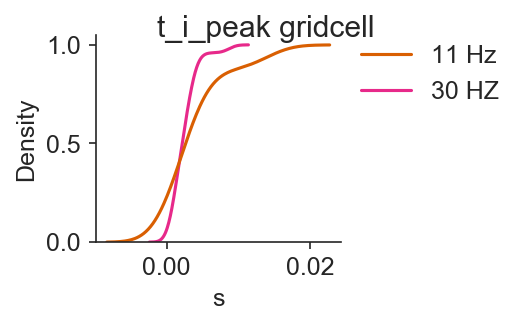

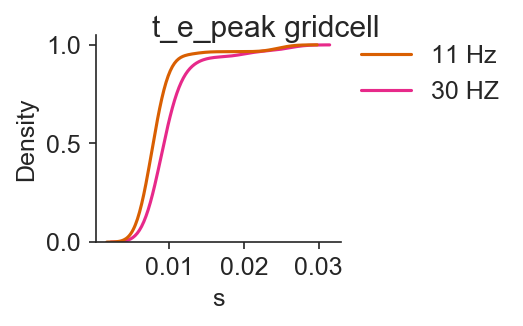

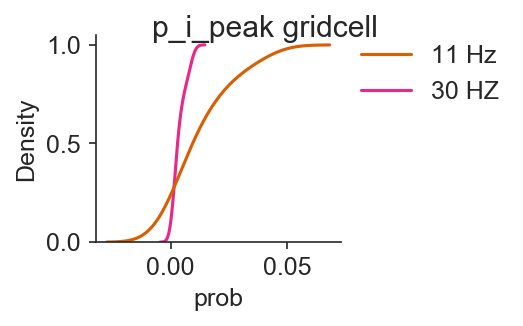

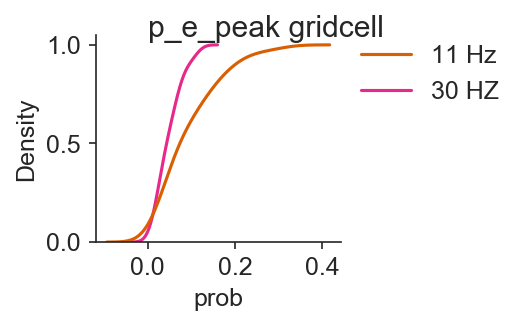

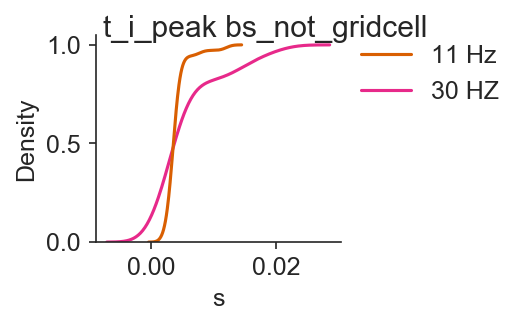

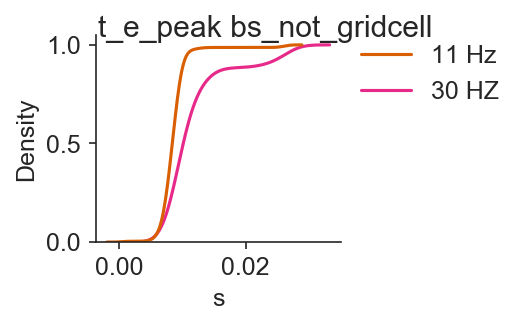

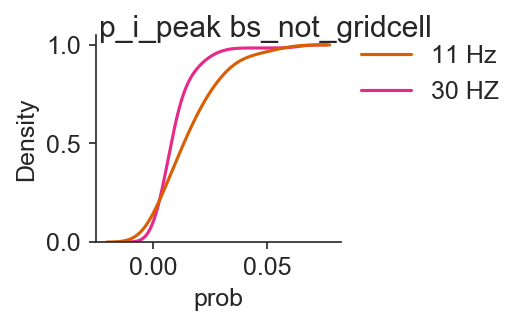

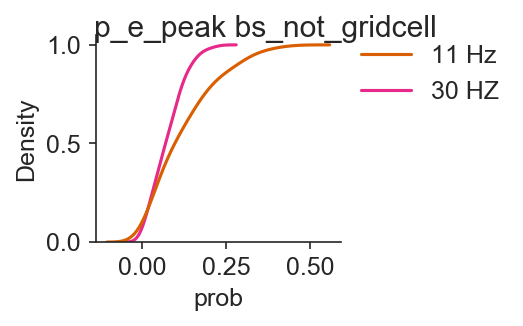

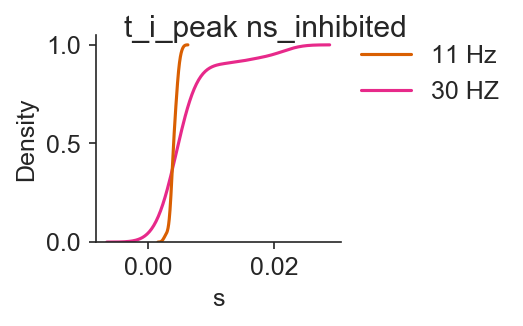

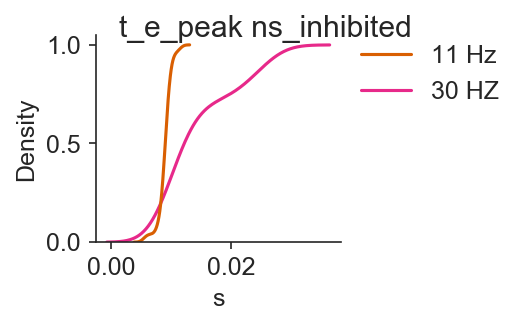

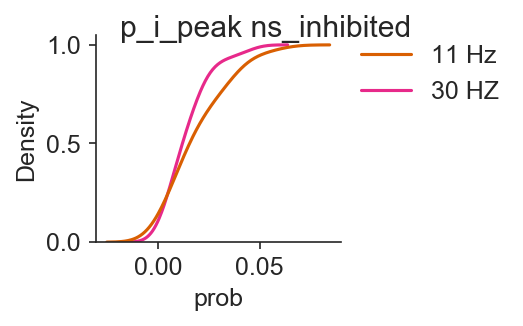

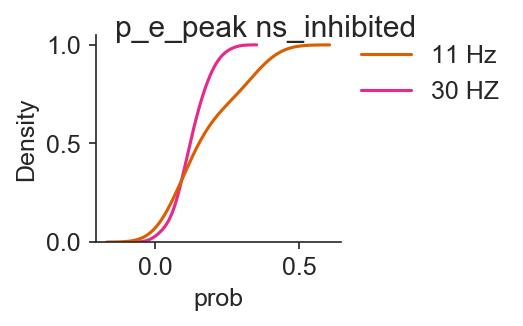

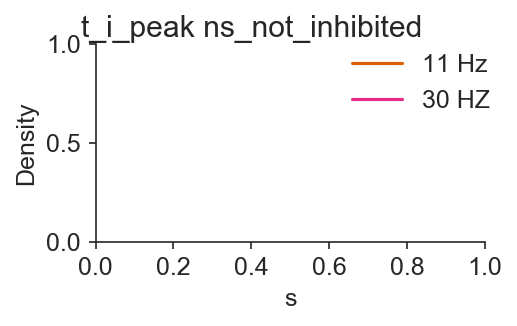

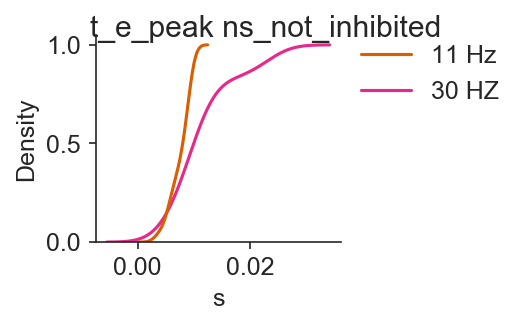

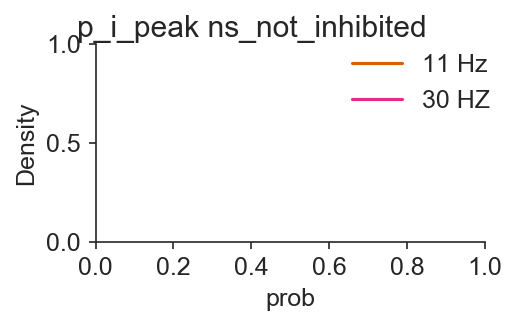

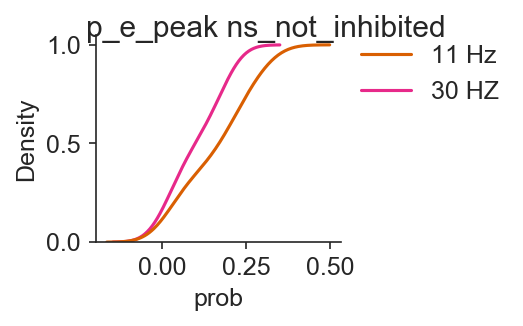

In [9]:

xlabel = {
    't_i_peak': 's',
    't_e_peak': 's',
    'p_i_peak': 'prob',
    'p_e_peak': 'prob',
}

for cell_type in ['gridcell', 'bs_not_gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.7,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

# Stats

In [10]:
stats = {}
for cell_type, result in results.items():
    stats[cell_type], _ = make_statistics_table(result, labels, lmm_test=True, wilcoxon_test=False, ttest_ind_test=True, ttest_rel_test=True)

In [11]:
stats['gridcell']

,T i peak,T e peak,P i peak,P e peak
11 Hz,3.1e-03 ± 1.2e-03 (8),8.5e-03 ± 3.2e-04 (58),1.0e-02 ± 4.5e-03 (8),1.2e-01 ± 1.1e-02 (58)
Normality 11 Hz,"1.6e+01, 2.9e-04","8.3e+01, 8.7e-19","4.2e+00, 1.2e-01","1.2e+01, 2.0e-03"
30 HZ,2.9e-03 ± 3.9e-04 (25),1.1e-02 ± 5.7e-04 (33),3.7e-03 ± 6.1e-04 (25),4.7e-02 ± 5.7e-03 (33)
Normality 30 HZ,"2.5e+01, 3.8e-06","4.8e+01, 3.2e-11","4.1e+00, 1.3e-01","2.9e+00, 2.4e-01"
T test ind 11 Hz - 30 HZ,"7.3e-01, 4.8e-01","-2.1e+00, 3.8e-02","1.7e+00, 1.4e-01","3.9e+00, 1.8e-04"
T test pair 11 Hz - 30 HZ,NaN,"1.5e-01, 8.8e-01",NaN,"2.5e+00, 3.6e-02"
LMM 11 Hz - 30 HZ,"5.9e-01 [-4.0e-03, 2.3e-03]","1.1e-02 [4.2e-04, 3.3e-03]","9.5e-03 [-1.3e-02, -1.8e-03]","4.5e-03 [-1.1e-01, -2.1e-02]"


In [12]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [13]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

# Plot PSTH

In [14]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [15]:
psth = pd.read_feather(output_path / 'data' / 'psth.feather')
times = pd.read_feather(output_path / 'data' / 'times.feather')

In [16]:
times = times.T.iloc[0].values

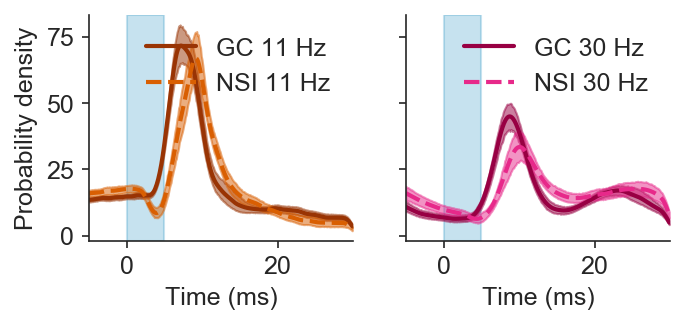

In [17]:
cs = ['#993404', '#980043', '#d95f02', '#e7298a']
lb = ['GC 11 Hz', 'GC 30 Hz', 'NSI 11 Hz', 'NSI 30 Hz']

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
ii = 0
for cell_type, ls in zip(['gridcell', 'ns_inhibited'], ['-', '--']):
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = psth.loc[:, selection].dropna(axis=1).to_numpy()

        plot_bootstrap_timeseries(times*1000, values, ax=ax, lw=2, label=lb[ii], color=cs[ii], ls=ls)
    #     ax.set_title(titles[i])
        ax.set_xlabel('Time (ms)')
        ax.legend(frameon=False)
        ii += 1
    axs[0].set_ylabel('Probability density')
    despine()
    plt.xlim(-5, 30)
for ax in axs.ravel():
    ax.axvspan(0, 5, color='#43a2ca', alpha=.3, zorder=-5)
figname = f'response-probability-gc-ns'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

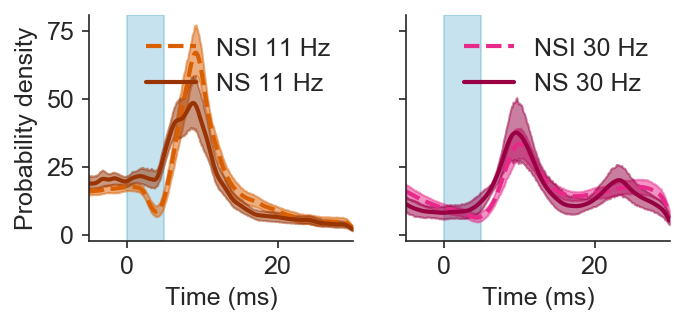

In [18]:
cs = ['#d95f02', '#e7298a', '#993404', '#980043']
lb = ['NSI 11 Hz', 'NSI 30 Hz', 'NS 11 Hz', 'NS 30 Hz']

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
ii = 0
for cell_type, ls in zip(['ns_inhibited', 'ns_not_inhibited'], ['--', '-']):
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = psth.loc[:, selection].dropna(axis=1).to_numpy()

        plot_bootstrap_timeseries(times*1000, values, ax=ax, lw=2, label=lb[ii], color=cs[ii], ls=ls)
    #     ax.set_title(titles[i])
        ax.set_xlabel('Time (ms)')
        ax.legend(frameon=False)
        ii += 1
    axs[0].set_ylabel('Probability density')
    despine()
    plt.xlim(-5, 30)
for ax in axs.ravel():
    ax.axvspan(0, 5, color='#43a2ca', alpha=.3, zorder=-5)
figname = f'response-probability-nsi-ns'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [19]:
action = project.require_action("stimulus-response")

In [20]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_ns_not_inhibited_p_i_peak.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_bs_t_i_peak.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_ns_not_inhibited_t_i_peak.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_ns_inhibited_p_e_peak.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_bs_not_gridcell_p_i_peak.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/statistics_gridcell.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_bs_t_e_peak.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/values_gridcell_p_i_peak.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-response/data/statistics/statistics_ns_inhibited.tex',
 '/media/storage/ex

In [21]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-response.ipynb")